In [11]:
import time
from collections import defaultdict
import json
import math
import random
import csv

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.use14corefonts'] = True
plt.rcParams['axes.unicode_minus'] = False  # https://stackoverflow.com/questions/43102564/matplotlib-negative-numbers-on-tick-labels-displayed-as-boxes
plt.style.use('seaborn-ticks')  # 'seaborn-ticks', 'seaborn-white', 'seaborn'

import os
import sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))  # Add the src directory to path 
from src.utils import tight_bbox
from src.plots import plot_quant_vs_ogtt

import seaborn as sns
import dateutil
from scipy.stats import spearmanr, pearsonr, kendalltau
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram, fcluster, fclusterdata

from sklearn.cluster import AgglomerativeClustering, FeatureAgglomeration
from sklearn.datasets import make_regression, make_classification
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LarsCV, LassoCV, LinearRegression, RidgeCV, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.cross_decomposition import PLSRegression

from sklearn.metrics import (
    classification_report,
    roc_auc_score, roc_curve, RocCurveDisplay, auc,
    confusion_matrix, multilabel_confusion_matrix, ConfusionMatrixDisplay,
    f1_score, 
    recall_score,
    accuracy_score,
    precision_score, precision_recall_curve, precision_recall_fscore_support,)
from sklearn.model_selection import (
    cross_val_score, cross_val_predict, cross_validate,
    RepeatedKFold, RepeatedStratifiedKFold, 
    StratifiedGroupKFold, GroupKFold, StratifiedKFold,
    train_test_split, 
    GridSearchCV,
    LeaveOneGroupOut,)
import sklearn
print(sklearn.__version__)
import shap

1.0.2


In [12]:
colors = json.load(open(r'..\data\metadata\color_schemes.json'))
colors['Non-fasted'] = colors['RBG']
colors['Fasted'] = colors['FBG']
compound_superclasses = json.load(open('../data/metadata/compound_superclasses.json', 'r'))
    
data = pd.read_csv(r'../data/processed/combined_metabolites_data_with_model_params.csv').set_index('i')
data_cols = data.filter(regex='_FBG|_RBG').columns
fbg_cols = data.filter(regex='_FBG').columns
rbg_cols = data.filter(regex='_RBG').columns

ap = pd.read_excel(r'..\data\metadata\animal_phenotypes.xlsx', index_col=0)
fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)

fg = fg.drop('1091_9_FBG')

In [20]:
X = data[data_cols].T
X_scaled = pd.DataFrame(StandardScaler().fit_transform(data[data_cols].T), index=data_cols, columns=data.index)

y_3class = fg['gluc_tol']                                                 # ['normal', 'impaired', 'diabetic']
y_3class_num = y_3class.map({'normal': 0, 'impaired': 1, 'diabetic': 2})  # [0, 1, 2]
y_bg = fg['bg']                                                           # random/fasted blood glucoose
y_ogtt = fg['animal'].map(ap['OGTT (AUC)'])
y_weight = fg['animal'].map(ap['Weightprefastweek12'])
y_insulin = fg['animal'].map(ap['Insulin (AUC)'])

In [21]:
ols = LinearRegression().fit(X, y_ogtt)

'm_453'

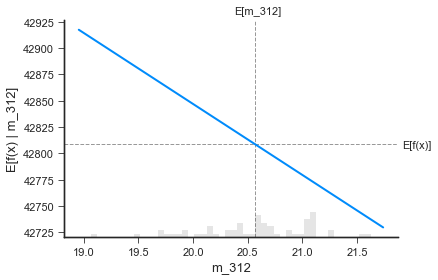

In [40]:
feature =  X.sample(axis=1).columns[0]
shap.partial_dependence_plot(feature, ols.predict, X, ice=False,
    model_expected_value=True, feature_expected_value=True)

In [46]:
explainer = shap.Explainer(ols.predict, X)
shap_values = explainer(X)

ValueError: max_evals=500 is too low for the Permutation explainer, it must be at least 2 * num_features + 1 = 2819!

# Example of SHAP for linear regression from 
https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html

In [47]:
import pandas as pd
import shap
import sklearn

# a classic housing price dataset
X_example, y_example = shap.datasets.california(n_points=1000)

X100 = shap.utils.sample(X_example, 100) # 100 instances for use as the background distribution

# a simple linear model
model = sklearn.linear_model.LinearRegression()
model.fit(X_example, y_example)

LinearRegression()

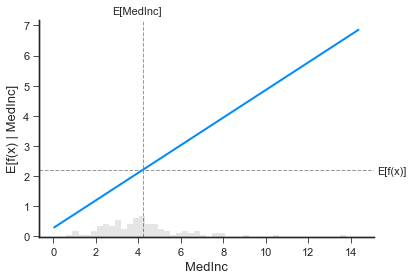

In [48]:
shap.partial_dependence_plot(
    "MedInc", model.predict, X100, ice=False,
    model_expected_value=True, feature_expected_value=True
)

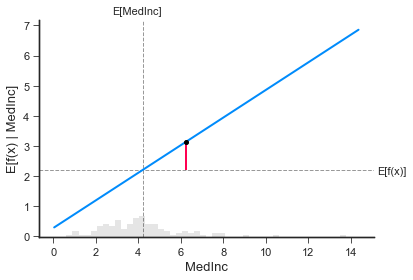

In [50]:
# compute the SHAP values for the linear model
explainer = shap.Explainer(model.predict, X_example)
shap_values = explainer(X_example)

# make a standard partial dependence plot
sample_ind = 20
shap.partial_dependence_plot(
    "MedInc", model.predict, X100, model_expected_value=True,
    feature_expected_value=True, ice=False,
    shap_values=shap_values[sample_ind:sample_ind+1,:]
)

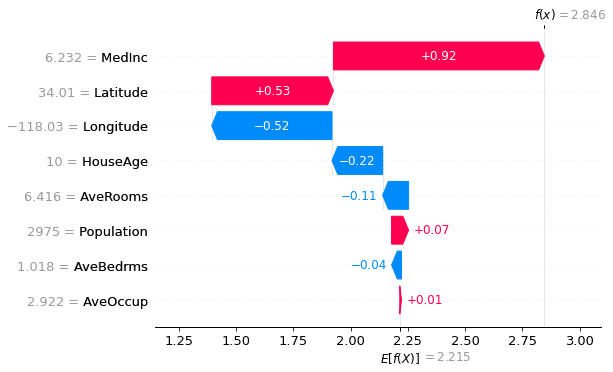

In [6]:
# the waterfall_plot shows how we get from shap_values.base_values to model.predict(X)[sample_ind]
shap.plots.waterfall(shap_values[sample_ind], max_display=14)

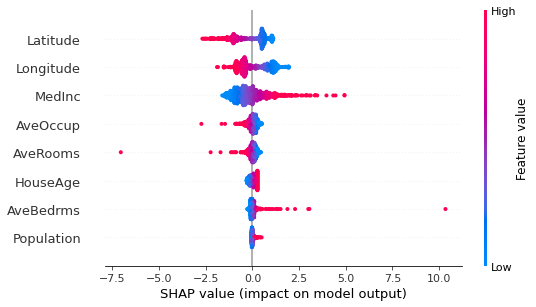

In [7]:
shap.plots.beeswarm(shap_values)